### Load Libraries

In [4]:

from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.callbacks import ModelCheckpoint
import string
import numpy as np
import PIL.Image

from os import listdir
from pickle import dump, load

from numpy import array
from numpy import argmax

from nltk.translate.bleu_score import corpus_bleu

In [5]:

def extract_features(directory):
    from IPython.core.display import display, HTML
    display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)

    print(model.summary())
    features = dict()

    for name in listdir(directory):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]

        features[image_id] = feature
        
    return features

In [6]:

directory = '../input/flickr8k_dataset/Flicker8k_Dataset'
features = extract_features(directory)

print('Extracted Features: ', len(features))
dump(features, open('features.pkl', 'wb'))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [7]:
listdir('../input')

['Flickr8k_text', 'flickr8k_text', 'Flickr8k_Dataset', 'flickr8k_dataset']

In [8]:

def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()

    file.close()
    
    return text


In [9]:
def photo_to_description_mapping(descriptions):
    description_mapping = dict()
    for line in descriptions.split('\n'):
        words = line.split()
        if len(line)<2:
            continue
        image_id, image_description = words[0], words[1:]
        image_id = image_id.split('.')[0]
        image_description = ' '.join(image_description)
       
        if image_id not in description_mapping:
            description_mapping[image_id] = list()
        description_mapping[image_id].append(image_description)
    
    return description_mapping

In [10]:
def clean_descriptions(description_mapping):
    table = str.maketrans('','', string.punctuation)
    
    for key, descriptions in description_mapping.items():
        for i in range(len(descriptions)):
            description = descriptions[i]
            description = description.split()
            
            description = [word.lower() for word in description]
            description = [word.translate(table) for word in description]
            description = [word for word in description if len(word)>1]
            description = [word for word in description if word.isalpha()]
            descriptions[i] = ' '.join(description)

In [11]:
def to_vocabulary(descriptions):
    all_desc = set()
    
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    
    return all_desc

In [12]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [13]:
filename = '../input/flickr8k_text/Flickr8k.token.txt'
doc = load_doc(filename)
descriptions = photo_to_description_mapping(doc)
print('Loaded: %d ' % len(descriptions))
clean_descriptions(descriptions)
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [14]:
def load_file(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

def load_photo_identifiers(filename):
    file = load_file(filename)
    photos = list()
    for line in file.split('\n'):
        if len(line) < 1:
            continue
        identifier = line.split('.')[0]
        photos.append(identifier)
    return set(photos)

def load_clean_descriptions(filename, photos):
    file = load_file(filename)
    descriptions = dict()
    for line in file.split('\n'):
        words = line.split()
        image_id, image_description = words[0], words[1:]
        if image_id in photos:
            if image_id not in descriptions:
                descriptions[image_id] = list()
            desc = 'startseq ' + ' '.join(image_description) + ' endseq'
            descriptions[image_id].append(desc)
            
    return descriptions
def load_photo_features(filename, photos):
    all_features = load(open(filename, 'rb'))
    features = {k: all_features[k] for k in photos}
    
    return features

In [15]:
filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'

train = load_photo_identifiers(filename)
print('Dataset: ',len(train))

train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))

train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000


In [16]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

def create_tokenizer(descriptions):
    lines = to_lines(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [17]:
tokenizer = create_tokenizer(train_descriptions)

vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)

Vocabulary Size:  7579


In [18]:

def max_lengthTEMP(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [19]:
def data_generator(descriptions, photos, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            photo = photos[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, photo)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, photo):
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [20]:
from keras.utils import plot_model
def define_model(vocab_size, max_length):
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    
    return model

In [21]:

filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
train_features = load_photo_features('features.pkl', train)
print('Photos: train=', len(train_features))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size:', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 20
steps = len(train_descriptions)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('model_' + str(i) + '.h5')

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7579
Description Length:  34
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
_____________________________________________________________________________________

In [22]:
listdir()

['model_0.h5',
 'model_19.h5',
 'model_12.h5',
 'model_2.h5',
 'model_10.h5',
 'model_4.h5',
 'features.pkl',
 '__notebook_source__.ipynb',
 'model_8.h5',
 'model_13.h5',
 'model_9.h5',
 'model_7.h5',
 'model_16.h5',
 'model_15.h5',
 'model_17.h5',
 'model_1.h5',
 'model.png',
 'model_11.h5',
 'model_3.h5',
 'model_18.h5',
 'model_5.h5',
 'model_6.h5',
 'descriptions.txt',
 'model_14.h5']

In [23]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        prob = model.predict([photo,sequence], verbose=0)
        prob = argmax(prob)
        word = word_for_id(prob, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

#the below function evaluates the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    for key, desc_list in descriptions.items():
        prediction = generate_desc(model, tokenizer, photos[key], max_length)
        actual_desc = [d.split() for d in desc_list]
        actual.append(actual_desc)
        predicted.append(prediction.split())

    print('BLEU-1: ', corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))

def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

In [24]:
filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', vocab_size)
max_length = max_lengthTEMP(train_descriptions)
print('Description Length: ,', max_length)

filename = '../input/flickr8k_text/Flickr_8k.testImages.txt'
test = load_photo_identifiers(filename)
print('Dataset: ', len(test))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=', len(test_descriptions))
test_features = load_photo_features('features.pkl', test)
print('Photos: test=', len(test_features))

filename = 'model_12.h5'
model = load_model(filename)
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Dataset:  6000
Descriptions: train= 6000
Vocabulary Size:  7579
Description Length: , 34
Dataset:  1000
Descriptions: test= 1000
Photos: test= 1000
BLEU-1:  0.5270817270624518


In [25]:
filename = '../input/flickr8k_text/Flickr_8k.trainImages.txt'
train = load_photo_identifiers(filename)
print('Dataset: ', len(train))
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=', len(train_descriptions))
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.pkl', 'wb'))

Dataset:  6000
Descriptions: train= 6000


In [26]:
def extract_features(filename):
    from IPython.core.display import display, HTML
    display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
    model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = argmax(yhat)
        word = word_for_id(yhat, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

tokenizer = load(open('tokenizer.pkl', 'rb'))
max_length = 34

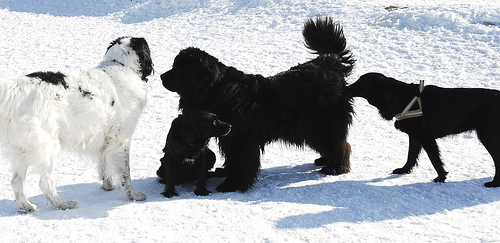

startseq two dogs are playing in the snow endseq


In [27]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/317383917_d8bfa350b6.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

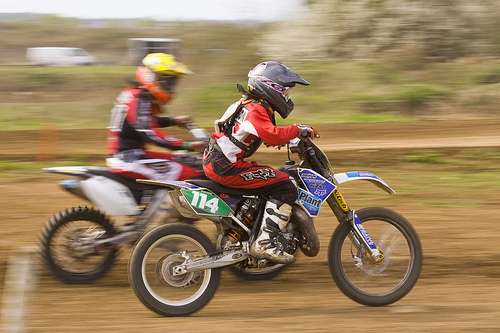

startseq dirt bike racer is turning through the air endseq


In [28]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/3437147889_4cf26dd525.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

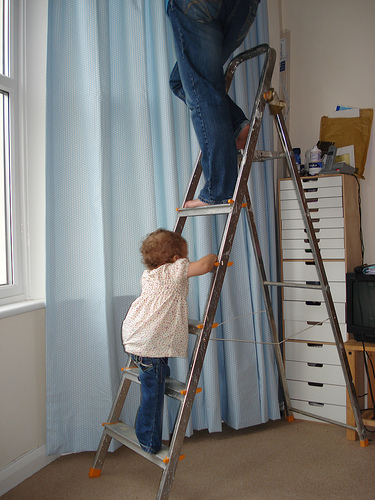

startseq two girls in red dresses dance endseq


In [38]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/350443876_c9769f5734.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

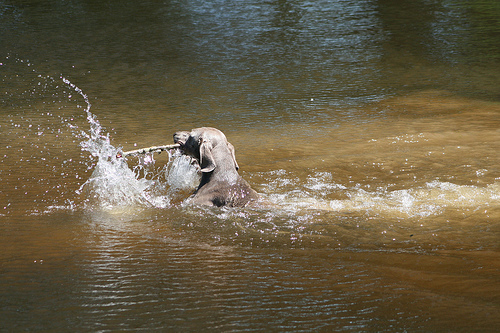

startseq dog swims through the water endseq


In [30]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/3498327617_d2e3db3ee3.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

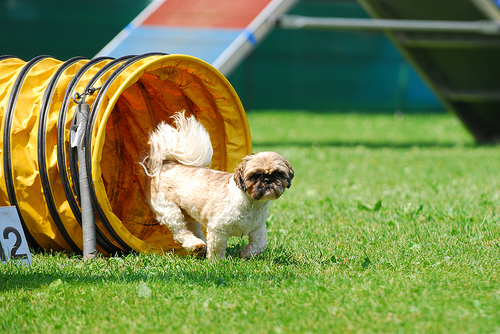

startseq dog is running through field endseq


In [39]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/745880539_cd3f948837.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

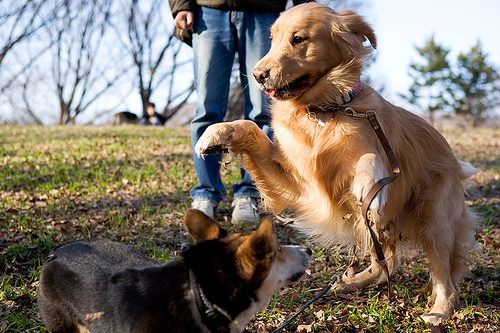

startseq two dogs are playing tug of war endseq


In [32]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/387830531_e89c192b92.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

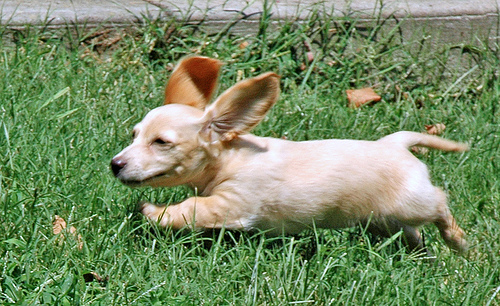

startseq dog is running through field endseq


In [33]:

model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/1119015538_e8e796281e.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

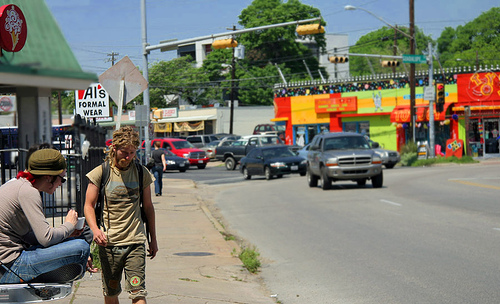

startseq group of people are walking down the street endseq


In [34]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/463978865_c87c6ca84c.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

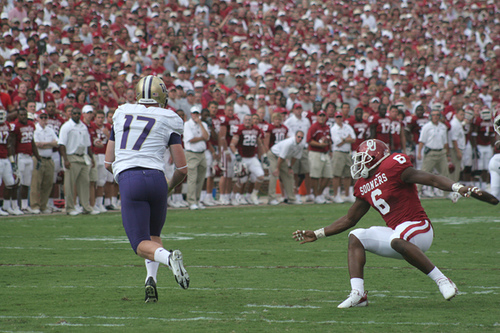

startseq baseball player in red is kicking soccer ball endseq


In [40]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/241346971_c100650320.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

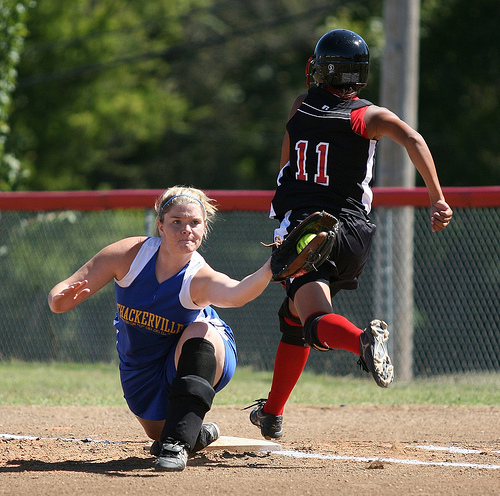

startseq two boys are playing softball endseq


In [41]:
model = load_model('model_19.h5')
path = '../input/flickr8k_dataset/Flicker8k_Dataset/2944952557_8484f0da8f.jpg'

from IPython.display import Image, display
z = Image(path)
display(z)
photo = extract_features(path)
   
description = generate_desc(model, tokenizer, photo, max_length)
print(description)